In [78]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from cvxpy import *

In [79]:
risk_free_rate = pd.read_csv(r'C:\Users\Administrator\Desktop\ORIE 5370\Project\DGS3MO_daily.csv', index_col=0, header=0)
risk_free_rate = np.array(risk_free_rate)
Price = pd.read_csv(r'C:\Users\Administrator\Desktop\ORIE 5370\Project\price_com_mat.csv', index_col=0, header=0)
Price = np.mat(Price)
nc = Price.shape[1]

In [80]:
Super = pd.read_csv(r'C:\Users\Administrator\Desktop\ORIE 5370\Project\super_big_data.csv', index_col=0, header=0)
#Super = np.mat(Super)
Returns = np.mat(Super.iloc[:,range(120,120+30,1)])
Variance = np.mat(Super.iloc[:,range(0,0+nc*3,3)])
Skewness = np.mat(Super.iloc[:,range(1,1+nc*3,3)])
Kurtosis = np.mat(Super.iloc[:,range(2,2+nc*3,3)])

In [81]:
random_signal = np.random.uniform(20,100,1255*30)
random_signal = random_signal.reshape([1255,30])
random_signal = pd.DataFrame(random_signal,columns=range(1,31,1),index=range(1,1256,1))
random_signal = np.mat(random_signal)
#random_signal(can be replaced by any signal)

In [82]:
def ranking(signal_matrix):
    rank_matrix = np.zeros(signal_matrix.shape)
    rank_matrix = np.mat(rank_matrix)
    #rank_matrix
    nc = signal_matrix.size/len(signal_matrix)
    for i in range(len(signal_matrix)):
        data_list = np.matrix.tolist(signal_matrix[i,:])[0]
        element_list = np.matrix.tolist(signal_matrix[i,:])[0]
        element_list.sort()  # list the signal values of each date from small to large
        #rankindex = [0]*nc   
        rank_index=range(30)
        r=1  # rank 1 has the smallest signal value
        while(len(element_list)!=0):        
            for j in range(nc):
                if(min(element_list)==data_list[j]):
                    rank_matrix[i,j] = r
                    del element_list[0]
                    r=r+1
                    break
    return rank_matrix
    ###########  end   ##########           

In [83]:
#########  PRECONDITION: number_of_colmns%number_of_groups==0 
def ngroupranking(signal_matrix,number_of_groups):
    rank_matrix = np.zeros(signal_matrix.shape)
    grouprank_matrix = np.zeros(signal_matrix.shape)
    print rank_matrix.dtype
    rank_matrix = np.mat(rank_matrix)
    grouprank_matrix = np.mat(grouprank_matrix)
    #rank_matrix
    nc = signal_matrix.size/len(signal_matrix)
    distance = nc/number_of_groups
    for i in range(len(signal_matrix)):
        data_list = np.matrix.tolist(signal_matrix[i,:])[0]
        element_list = np.matrix.tolist(signal_matrix[i,:])[0]
        element_list.sort()  # list the signal values of each date from small to large
        #rankindex = [0]*nc   
        rank_index=range(30)
        r=1  # rank 1 has the smallest signal value
        while(len(element_list)!=0):        
            for j in range(nc):
                if(min(element_list)==data_list[j]):
                    rank_matrix[i,j] = r
                    grouprank_matrix[i,j] = float(int(r-1)/int(distance)+1)
                    del element_list[0]
                    r=r+1
                    break
    return rank_matrix,grouprank_matrix
    ###########  end   ##########        
test = ngroupranking(Skewness,3)[1]
for i in range(1000):
    for j in range(20):
        if (test[i,j]!=1.0 and test[i,j]!=2.0 and test[i,j]!=3.0):
            print i,j,test[i,j]

float64


In [84]:
def investor_view(Signal,Returns,trade_date,signal_sample_frequency,number_of_signal_samples,rate_of_signal_decay):
    #signal: the larger value, the better

    S = Signal # the Signal matrix, each row refer to a date and each column refers to an asset
    R = Returns
    t_d = trade_date # the date you trade, 0,1,2...
    s_f = signal_sample_frequency #num
    n_s = number_of_signal_samples #num
    r_d = rate_of_signal_decay #num
 
    s_d = t_d-1-np.arange(n_s)*s_f #reverse chronological
    #s_d = t_d-np.arange(n_s+1)*s_f #### We can take the ideal case where we can trade near the close, 
                                   #### we no longer need to minus 1
    s_d = s_d[::-1] #chronological    
    #sample dates, a row vector

    S_S = S[s_d,:] #Sample Signals, a matrix
    S_R = R[s_d,:] #Sample Returns

    #now it ’s time to construct the weight
    w = (1.0-float(r_d))**np.arange(n_s)
    w = w[::-1]
    w = w/sum(w)
    wt = np.transpose([w])  #weights, a non-negative vector that sums to 1
    mean_c_r = S_S.T*wt  #mean vector of compound returns
    #print mean_c_r.T
    view_rank = ngroupranking(mean_c_r.T,3)[1].T
    #print ngroupranking(mean_c_r.T,3)[1].dtype
    #print mean_c_r.dtype
    #print view_rank.dtype
    #print view_rank
    view_rank = view_rank%3
    view_rank = view_rank%2
    ###########    View on the skewness    ########
    skewness_small = view_rank.T
    ####
    var_skewness = np.var(S_S)# the var of 
    A = skewness_small
    Omega = np.mat(var_skewness)
    b_skewness = np.sum(S_R*A.T)
    b = np.mat(b_skewness)
    return A,Omega,b
atest = investor_view(Skewness,Returns,120,1,5,0)[0]

float64


In [85]:
#Calculate mu and V
##### PRECONDITION: sample_frequency*number_of_samples < trade_date  
def adapted_stats(Price,trade_date,horizon,sample_frequency,number_of_samples,rate_of_decay):  
    h = horizon # 
    P = Price # the Price matrix, each row refer to a date and each column refers to an asset
    t_d = trade_date # the date you trade, 0,1,2...
    s_f = sample_frequency #num
    n_s = number_of_samples #num
    r_d = rate_of_decay #num

    s_d = t_d-1-np.arange(n_s+1)*s_f #reverse chronological   
    s_d = t_d-np.arange(n_s+1)*s_f #### We can take the ideal case where we can trade near the close, 
                                   #### we no longer need to minus 1
    s_d = s_d[::-1] #chronological    
    #sample dates, a row vector

    S_P = P[s_d,:] #Sample Prices, a matrix
    

    S_C_R = np.log(S_P[1:,:]/S_P[:-1,:]) #Sample Compound Returns, a matrix
    #now it ’s time to construct the weight
    w = (1.0-float(r_d))**np.arange(1,n_s+1)
    w = w[::-1]
    w = w/sum(w)
    wt = np.transpose([w])  #weights, a non-negative vector that sums to 1
    mean_c_r = S_C_R.T*wt  #mean vector of compound returns
    Cov_C_R = (S_C_R.T*np.diag(w)*S_C_R)-mean_c_r*np.transpose([mean_c_r])
    #covariance matrix of compound returns

    adapted_mean_c_r = mean_c_r*(float(h)/float(s_f))
    #adapting mean vector to reflect length of holding period
    
    Adapted_Cov_C_R = Cov_C_R*(float(h)/float(s_f))
    #adapting covariance matrix to length of holding period

    muu = np.exp(adapted_mean_c_r + 0.5*np.mat(np.diag(Adapted_Cov_C_R)).T)
    mu = muu - 1
    #resulting mean vector of ARITHMETIC returns
    
    V = np.multiply((muu*np.transpose([muu.T])),(np.exp(Adapted_Cov_C_R)-1))
    #resulting covariance matrix of ARITHMETIC returns   
    
    return mu,V

In [86]:
a = np.random.uniform(0,1,10000)
b = np.random.uniform(0,1,10000)
a = a.reshape([100,100])
b = b.reshape([100,100])
np.linalg.inv(a)
np.linalg.inv(np.linalg.inv(a)+np.linalg.inv(b))
a.dtype
a.dtype='float32'
a.dtype

dtype('float32')

In [87]:
def blacklitterman(mu0,mu,V,sigma,xx0,xx,trans_cost,A,Omega,b):
    n = len(mu)
    print b
    print "Omega.shape:",Omega.shape
    print "Omegainv",np.linalg.inv(Omega)
    print "V.shape:",V.shape
    print "Vinv",np.linalg.inv(V)
    print Omega.dtype
    print V.dtype
    print A.dtype
    #print (A.T*np.linalg.inv(Omega)*A+np.linalg.inv(V)).shape
    middle = np.mat(A.T*Omega.I*A+V.I)
    print middle.dtype
    #middle.dtype = 'float32'
    print middle.shape
    #print np.linalg.det(middle)
    #print np.linalg.det(A.T*np.linalg.inv(Omega)*A+np.linalg.inv(V))
    #print 
    W = middle.I
    
    BL_mu = W*(A.T*np.linalg.inv(Omega)*b+np.linalg.inv(V)*mu) 
    
    U = np.linalg.cholesky(W)

    x0 = Variable(1)
    x = Variable(n)
    y = Variable(n)
    total_trans_cost = Variable(1)
        
    objective = Maximize(mu0*x0+BL_mu.T*x)
    constraints = [norm(U*x)<=sigma,
                   x0+sum_entries(x)+total_trans_cost==1,
                   x==xx+y,
                   trans_cost*sum_entries(abs(y))<=total_trans_cost,
                   x0>=0,
                   max_entries(abs(x-1.0/(n+1)))<=0.02,
                   #0.05<=x,
                   #x<=0.2,
                   #x[1]+x[4]<=x[5]+x[6]+x[8],
                   #sum_smallest(x,4)>=-1.25
                   ]
    prob = Problem(objective, constraints)
    result = prob.solve()
    prob.solve()  # Returns the optimal value.
    return x0.value,x.value

In [88]:
def rebalance_benchmark(benchmark_x0,benchmark_x,trans_cost):
    n = np.size(benchmark_x)
    z = Variable(1)
    objective = Maximize(z)
    constraints = [(n+1)*z <= benchmark_x0+sum_entries(benchmark_x)-trans_cost*sum_entries(abs(z-benchmark_x))]
    prob = Problem(objective, constraints)
    result = prob.solve(solver=ECOS)
    prob.solve()
    return z.value

In [89]:
###############  BACKTEST  ###############
n = np.size(Price)/len(Price) # n=number of risky assets
e = np.ones([n,1])

###############
#### PARAMETERS
#### (the following choices of parameters can easily be changed)

horizon = 5 # rebalance daily
##### PRECONDITION: sample_frequency*number_of_samples < trade_date  
start = 120 # the day on which you are first given a portfolio to rebalance
number_rebalances = 200 # the number of times the portfolio will be rebalanced 
number_of_samples = 20 # how many samples are to be used 
                      # in computing return avereages and covariances
sample_frequency = 1 # 1 = daily, 2 = , etc.
r_w_f_o_y_e = 0.2 # "relative weight for one year earlier" 
                 # -- a value .4 means that for the (exponential) weights 
                 # used in computing return averages and covariances, 
                 # the weight assigned to the time period one year ago
                 # should be .4 times the weight assigned 
                 # to the most recent period.     
allowable_risk = 1
    # This is the level of risk relative to the benchmark portfolio,
    #   where risk is measured as standard deviation of portfolio returns.
    # Choosing this value to equal 1 means exactly the same amount of risk is allowed,
    # whereas choosing 2 means twice as much risk is allowed as the benchmark, and so on.
trans_cost = 0.0008  # transaction cost
wealth = 10000 # initial wealth measured in dollars, including money invested in assets
               # (one dollar invested in an asset is considered as one dollar of wealth,
               #  even though in liquidating the asset, transaction costs would be paid)   
x0 = 0.3 # proportion of wealth in bank initially
x = (0.7/n)*e # proportions in risky assets initially
Signal = Skewness
signal_sample_frequency = 1
number_of_signal_samples = 5
rate_of_signal_decay = 0
# Assume the benchmark portfolio is initally equal-weighted, with 1/(n+1) being the 
# proportion of wealth invested in each asset and in the bank.
#### END OF PARAMETERS
######################
#rate_of_decay = 0
rate_of_decay = 1 - r_w_f_o_y_e**(sample_frequency/52.0)
initial_wealth = wealth
benchmark_wealth = wealth
portfolio_value = [wealth]
benchmark_value = [wealth]
rebalance_dates = start + horizon*np.arange(number_rebalances)

for i in range(len(rebalance_dates)):
    trade_date = rebalance_dates[i]

    ###### REBALANCE YOUR PORTFOLIO AND PAY TRANSACTION COSTS ######
    # It is more natural to rebalance the benchmark portfolio later #
    A,Omega,b = investor_view(Signal,Returns,trade_date,signal_sample_frequency,number_of_signal_samples,rate_of_signal_decay)   
    A.dtype = 'float64'
    
    mu,V = adapted_stats(Price,trade_date,horizon,sample_frequency,number_of_samples,rate_of_decay)
    #[mu,V] = stats(Price,trade_date,sample_frequency,number_of_samples,rate_of_decay)
    
   
    
    mu0 = (1+0.01*risk_free_rate[trade_date-1])**(float(horizon)/255.0)-1
    
    #benchmark_risk = sqrt(quad_form(e, V))/n # there are n assets in the portfolio
    benchmark_risk = sqrt(quad_form(e,V))/(n+1)  # there are n+1 financial instruments
                                                        # including the bank
    sigma = allowable_risk*benchmark_risk
    
    xx0 = x0
    xx = x
    x0,x =  blacklitterman(mu0,mu,V,sigma,xx0,xx,trans_cost,A,Omega,b)
    wealth = wealth*(x0+sum(x))
        # This is the same thing as updating your wealth by subtracting
        # all transaction costs from the rebalancing.  Indeed, in rebalancing,
        # the proportion of your wealth going to trans costs is 1 - x0 - sum(x).  
        
    total = x0+sum(x)
    x0 = x0/total
    x = x/total
        # Rescaling x0 and x so that the sum is 1 (i.e., proportions of current wealth)
    
    ###### PROCEED TO END OF TIME PERIOD AND ACCOUNT FOR GAINS, LOSSES ######
    
    returns = (Price[trade_date+horizon-1,:]-Price[trade_date-1,:])/Price[trade_date-1,:]
        # vector of actual returns for risky assets (this is a row vector)
    
    multiplier = 1+mu0*x0+returns*x
    wealth = multiplier*wealth
            # by leaving off the semicolon, you can watch how wealth changes as the program runs

    if(wealth<=0):
        break   # stops the program if bankruptcy occurs
                # Not needed for benchmark portfolio (because it is long only)
    
    x0 = (1+mu0)*x0/multiplier
    x = np.multiply(x,np.transpose(1+returns))/multiplier
    # these are the proportions of current wealth invested in assets
    # Now its time to rebalance the benchmark portfolio and pay transaction costs
    
    benchmark_x0 = (1+mu0)/(n+1)
    benchmark_x = (1+returns)/(n+1)
    # This gives how the equal-weighted portfolio has changed during the time period.
    # The initial unit of wealth has become  benchmark_x0 + sum(benchmark_x).
    # This new level of wealth needs to be distributed equally among the assets and bank.
    # The optimal amount z to put into each one is determined by the following function,
    # which finds the value z so as to minimize transaction costs
    
    z = rebalance_benchmark(benchmark_x0,benchmark_x,trans_cost) 
    benchmark_wealth = benchmark_wealth*(n+1)*z
    # Until the end of the next time period, 
    # think of the benchmark portfolio as having been rebalanced
    # with wealth divided equally, that is, the portion of wealth invested in
    # each asset and the bank is 1/(n+1).
    
    portfolio_value.append(wealth)
    benchmark_value.append(benchmark_wealth)

float64
[[ 0.03489947]]
Omega.shape: (1L, 1L)
Omegainv [[ 1.07983768]]
V.shape: (30L, 30L)
Vinv [[  1.90032116e+06   3.56898046e+05  -5.82898916e+05  -4.41691784e+05
   -1.04931984e+06  -7.41043793e+05   4.67469959e+05  -4.85178095e+03
   -6.31951944e+04  -2.95748960e+05   9.89879118e+05  -1.41614542e+06
   -1.19815717e+05   8.69700001e+05  -3.64859113e+05   7.98590240e+05
   -1.09985812e+06   7.13026645e+05  -6.21660077e+04   4.40339791e+05
   -2.88678269e+05  -1.24835127e+06   3.96958444e+05   3.22310412e+06
   -3.25838018e+05   2.42416936e+06   3.36026584e+05   4.81942144e+04
    2.17553456e+05   2.06881131e+06]
 [  3.56898046e+05   6.17438043e+07  -5.80449417e+05   2.21635486e+06
    6.11667019e+06   4.71228154e+06  -1.05767295e+07   6.97633895e+05
   -2.42384153e+07  -1.01780032e+07  -9.00952441e+06   1.83445361e+06
   -5.65667536e+05   2.98592363e+07   2.28422130e+06  -1.55245108e+06
   -1.34202116e+07  -6.11196020e+06   4.48768494e+06   1.58426308e+06
    4.29150964e+06  -6.1933

float64
[[ 0.02891265]]
Omega.shape: (1L, 1L)
Omegainv [[ 0.77890242]]
V.shape: (30L, 30L)
Vinv [[  1.18962580e+08   3.24290091e+07  -8.96950589e+06  -7.02076220e+06
   -7.45334448e+07   2.42288668e+06  -1.20482522e+07  -9.30077995e+06
    8.13156028e+06  -2.29960126e+07  -1.79232489e+07  -3.71985205e+07
    1.36863154e+07  -4.18949173e+06  -1.95283169e+07   7.58632742e+06
    5.80968862e+07   4.13240059e+07  -1.53972466e+07  -2.29845235e+07
    4.76150265e+05   1.12235316e+07  -1.61402231e+07  -2.73367511e+07
    3.35554617e+06  -2.69790296e+07  -6.72489293e+05   2.97288368e+06
    1.32001270e+07  -6.05540182e+06]
 [  3.24290091e+07   2.47650488e+07  -1.20100954e+06  -2.86649888e+06
   -3.14292009e+07  -2.28898113e+06  -8.15833125e+06  -2.52121139e+06
    7.62186461e+06  -9.93345185e+06  -3.46301737e+06  -1.46791064e+07
   -4.80469589e+06  -2.09602717e+06  -1.15173300e+07   1.19777774e+07
    1.41080161e+06   7.39071907e+06   1.14654508e+07  -7.13755490e+06
   -5.05661048e+05  -3.3018

float64
[[ 0.00177465]]
Omega.shape: (1L, 1L)
Omegainv [[ 2.16013484]]
V.shape: (30L, 30L)
Vinv [[  4.32254339e+07  -5.44112807e+06  -2.37153843e+06  -6.34722562e+06
    2.78247367e+06  -8.43932682e+06   6.26806376e+05  -3.29590596e+06
    1.91116320e+07   8.34223609e+06   1.35866998e+07  -2.62508186e+07
    8.11865927e+05   1.18151942e+07  -1.62427149e+07   1.10368204e+07
    2.13693728e+07  -2.37244710e+07  -9.14765137e+06  -1.88933881e+07
    1.63093861e+04   2.93777164e+06  -4.44318400e+07  -2.81908892e+07
    1.64625537e+05   2.18037684e+07  -5.68949730e+06  -9.14066375e+06
   -2.37788267e+06   5.12912826e+06]
 [ -5.44112807e+06   4.50686767e+07   1.17945667e+07   1.96572171e+06
   -2.61386507e+06   7.29628810e+06  -2.24650536e+07   2.01878694e+06
   -1.08222043e+07  -4.82374450e+06  -2.27283112e+07   2.35458100e+06
    7.72054823e+06   6.34138492e+06  -1.67652273e+07  -3.18239117e+06
   -7.40054004e+06   3.12817788e+06  -1.17925322e+07  -1.44999663e+07
   -8.85099870e+05   2.7061

Omega.shape: (1L, 1L)
Omegainv [[ 1.51279494]]
V.shape: (30L, 30L)
Vinv [[  2.73769087e+07  -6.20230859e+05   7.09792328e+05   4.39250888e+05
    8.66569117e+05   1.04378534e+07   7.27609091e+06  -2.46125227e+06
   -1.05677098e+06  -2.69421124e+06  -3.76718029e+06   8.89641802e+05
   -3.92894533e+06   1.17430824e+07   1.90204919e+06  -2.33594972e+06
    2.35156670e+03   3.20941886e+07  -1.41030743e+07  -2.48802586e+07
   -1.16122286e+06  -4.88279682e+07  -6.78836770e+06  -5.45480962e+05
   -2.68814937e+06   1.10776008e+07  -7.69928288e+06   4.84815659e+06
   -5.13502178e+06  -1.82553653e+07]
 [ -6.20230859e+05   2.32483584e+06   1.12592910e+05  -4.29217891e+04
    7.47170121e+05  -4.94821381e+05  -9.22567226e+05   8.70984390e+04
   -5.27207151e+05  -5.90213468e+05  -8.29649461e+04   1.67772630e+05
   -3.82280871e+05   5.53282957e+05   1.12547265e+05  -4.46391458e+05
    2.04523668e+05  -2.88690573e+06  -1.32219781e+06   1.14666328e+06
   -5.52382027e+05   6.07214909e+05   8.46387532e+0

float64
[[ 0.0250879]]
Omega.shape: (1L, 1L)
Omegainv [[ 1.01563166]]
V.shape: (30L, 30L)
Vinv [[  4.96692702e+06   1.44590668e+06  -2.21087993e+06   1.15705027e+06
    2.50319143e+05   1.82893211e+06  -1.56455965e+06  -6.90496548e+05
   -2.84568663e+05   3.07707610e+05  -3.14869674e+06  -1.52651579e+06
    3.89277587e+05  -4.82466086e+05  -2.79665932e+06   1.03114946e+06
   -4.13253987e+06   1.74484036e+05   6.36860896e+05  -3.27661072e+05
   -1.54226379e+06  -1.21127695e+06   7.57536216e+06  -9.99681700e+05
   -7.20161319e+05   5.59535718e+06   3.28530572e+06  -9.85018463e+05
   -6.40874825e+04  -6.48662310e+06]
 [  1.44590668e+06   3.85464325e+07   3.45069485e+06  -7.26751682e+06
    6.21775636e+05   1.76795796e+06  -2.90605044e+06  -4.71474337e+06
   -7.83041569e+05   9.83002157e+05  -2.26726412e+07   5.44484116e+06
   -6.96903303e+06  -5.73089311e+06  -7.52584659e+06   3.56910286e+06
    3.00795898e+07  -7.19579556e+06  -4.74710544e+06  -5.96184888e+06
   -1.29541978e+05   6.86970

Omega.shape: (1L, 1L)
Omegainv [[ 1.19539981]]
V.shape: (30L, 30L)
Vinv [[  2.63673018e+06   2.93854571e+06   6.97777408e+05   1.64099906e+06
   -9.24069065e+05  -1.16799813e+06   1.30961738e+06   4.80726273e+05
    1.68157589e+04   1.06649325e+05   7.08966181e+05  -2.41548650e+06
   -9.99974139e+05   3.17614426e+06   7.73087639e+05   4.06680851e+06
   -1.02857578e+06   1.19521139e+06  -1.69347063e+06  -1.87906770e+06
   -3.35020523e+05   6.32214382e+05  -1.98779725e+06  -6.09291622e+05
   -2.53662261e+06  -2.90863630e+06   6.20479172e+04   5.48225233e+05
    2.66509938e+05   1.29472060e+06]
 [  2.93854571e+06   2.00361791e+07   9.54877866e+05   2.20470982e+06
   -1.08972359e+07   1.48593123e+06   2.55344605e+05   3.35424772e+06
   -1.15321722e+06   1.88963741e+06   2.02295717e+06  -1.33798637e+07
   -2.84397981e+06  -1.32717103e+06  -6.05704527e+06   1.28990728e+07
   -8.95017729e+06   5.34398962e+06  -6.59085478e+06  -1.62138816e+06
    3.76740115e+05  -4.15681486e+05  -5.45182888e+0

Vinv [[  1.81592055e+07  -1.54048366e+06   3.82961055e+06   2.78657117e+06
   -1.64540743e+07  -9.82891868e+05   2.10729402e+06  -3.02691419e+06
    8.73930686e+05  -2.18087833e+06   1.08740672e+06   9.64561494e+06
    4.98817695e+05   7.54902261e+06  -4.76123965e+05   6.83902578e+06
    9.86884540e+05   4.00248131e+06   1.38749744e+06  -5.34046740e+06
   -3.26175894e+05  -7.70241891e+06   8.90506967e+05  -2.62859472e+06
    3.63930337e+06  -1.97944370e+07   1.03889195e+06  -2.57567180e+06
   -5.72050838e+05  -4.12323554e+05]
 [ -1.54048366e+06   2.83221155e+07   9.88735589e+06   2.06831997e+06
    8.19434302e+06   1.68409386e+06   4.25271690e+05   3.92491584e+06
   -2.08835955e+06   1.38247619e+06  -1.40828119e+06  -1.28445105e+07
   -6.18976844e+06   7.22650229e+06  -3.66829074e+06  -2.42472142e+07
   -3.29790322e+06  -7.43253408e+06  -6.39816905e+06   2.73256706e+06
   -7.83609992e+05   4.98008307e+06  -1.01151270e+07   1.07084484e+07
   -9.25984830e+06   2.66800938e+06   1.49699678

float64
[[ 0.01658702]]
Omega.shape: (1L, 1L)
Omegainv [[ 1.50330193]]
V.shape: (30L, 30L)
Vinv [[  1.61248914e+06  -8.04272735e+05  -9.72901946e+04   3.06350263e+05
    9.29026063e+05   1.43733829e+06   2.25509155e+05  -8.49264404e+05
   -3.82536879e+05   1.93980363e+05  -2.41132936e+05   9.48801488e+05
   -1.51645127e+06  -6.21986032e+05   2.38144985e+05   4.17017924e+06
   -1.16289071e+06   3.99268167e+05   1.35691323e+05   1.37244282e+05
    9.71206954e+05   1.15526186e+06   1.85975550e+06   8.28330822e+05
    5.05216394e+05  -5.20470366e+05  -4.36198740e+05  -2.27619387e+05
   -7.98577319e+05  -7.38070499e+05]
 [ -8.04272735e+05   1.81470334e+07   1.24137938e+05   1.11690156e+06
   -1.97236268e+06  -2.49669009e+06   1.79758665e+05   7.53989167e+06
   -1.12439822e+06   1.03478548e+06  -2.90035535e+06   2.16252633e+06
   -3.12975193e+05  -5.81805694e+06  -7.47078223e+06  -7.80862152e+06
   -1.29801916e+06   2.10516270e+06   2.07613971e+06  -4.81594758e+06
    1.16377999e+06  -2.7672

   -2.07783395e+07   1.15434824e+08]]
float64
float64
float64
float64
(30L, 30L)
float64
[[-0.12432224]]
Omega.shape: (1L, 1L)
Omegainv [[ 1.48763097]]
V.shape: (30L, 30L)
Vinv [[  6.06108936e+06  -7.38352422e+05  -1.10374046e+06   2.52403795e+06
   -1.08728421e+06  -3.67358980e+06   2.74313195e+05   1.14869981e+06
   -1.85262270e+06  -3.36067623e+05  -9.59111954e+05   6.42431438e+06
    1.37495335e+06   2.88597119e+06   5.63347309e+05  -3.85658452e+06
    1.82445987e+06   4.15932843e+06   1.03722256e+06  -4.02718125e+06
    1.74418751e+06  -6.40961300e+06   5.83704826e+06  -3.04127745e+05
   -2.51827104e+06  -1.12322577e+06  -4.84983716e+06  -2.47039001e+06
   -7.30273011e+04   1.61051054e+06]
 [ -7.38352422e+05   1.37168224e+07  -2.12519916e+05   4.38892204e+05
   -2.14445873e+06  -2.69057560e+06  -2.50629790e+06   1.25518464e+06
    1.53387545e+06   4.73504313e+05   1.43269340e+06   1.83163663e+06
   -8.72650541e+06  -1.85935026e+06  -2.27672410e+06  -6.77309628e+06
    2.03236270e+

float64
[[-0.09506232]]
Omega.shape: (1L, 1L)
Omegainv [[ 0.87587947]]
V.shape: (30L, 30L)
Vinv [[  4.25324958e+06  -1.81747174e+06   5.94804748e+05  -7.60951228e+05
   -1.35202781e+06   4.16019996e+05   6.47417826e+05   1.03488035e+06
   -1.03513201e+05  -1.08917676e+06  -1.15900376e+06   3.03048064e+06
    4.60070584e+05   2.15012253e+06  -8.40235356e+05   3.86724722e+06
    1.41361766e+06  -1.94377648e+06  -8.98288967e+05  -2.58705178e+06
   -3.39533949e+06   1.88191892e+06  -2.96906871e+06   3.31573748e+05
   -2.30440488e+06  -5.98750965e+04  -3.68017049e+05   2.23475644e+05
   -1.17980626e+06  -2.54656152e+06]
 [ -1.81747174e+06   2.41897285e+07   7.06454798e+06  -1.07579047e+07
    2.04105614e+06  -5.75208655e+05  -3.08888425e+06  -2.09480093e+05
    9.81058906e+05  -2.44074323e+06   4.89811182e+06  -2.76996515e+06
   -9.47710944e+06  -1.15892121e+06  -2.96851932e+06   6.19262167e+05
   -3.01449395e+05  -5.96843636e+04   3.77406288e+06  -5.92503589e+06
    1.29940587e+06   7.9031

   -1.16135924e+06   7.12719104e+07]]
float64
float64
float64
float64
(30L, 30L)
float64
[[-0.08835097]]
Omega.shape: (1L, 1L)
Omegainv [[ 1.09858698]]
V.shape: (30L, 30L)
Vinv [[  4.13531027e+06  -2.33942818e+06   3.65154703e+05   9.79455939e+05
   -6.90325524e+05   1.67571718e+06   2.43620788e+06   9.83791746e+05
    1.08753174e+05   5.55583314e+05   4.85542212e+06   2.46313726e+04
   -1.65516894e+06  -4.93780954e+05  -3.42312208e+06  -4.15138773e+06
    3.00212597e+06   3.95790118e+05  -3.39880272e+06  -8.28643909e+05
    7.34123861e+05  -6.31903832e+05  -1.91450025e+06   1.83331413e+06
   -2.87955171e+05  -3.30836826e+05  -3.65887346e+06   1.44407451e+06
    1.38568406e+06  -1.21750300e+07]
 [ -2.33942818e+06   6.53495456e+06  -8.46302853e+05  -1.99386082e+06
    8.31071418e+05   4.59651236e+06   1.39107976e+06   4.76319718e+05
   -2.43100067e+05   1.38481269e+06  -8.37530783e+06  -1.08933127e+05
   -3.35663924e+06   2.49495091e+06  -8.52048420e+05  -1.04616079e+06
   -3.67593429e+

float64
[[-0.13210028]]
Omega.shape: (1L, 1L)
Omegainv [[ 1.14046963]]
V.shape: (30L, 30L)
Vinv [[  8.31034692e+05  -1.05333170e+06  -1.39438232e+05   1.20856767e+05
   -3.91930124e+04  -2.26640176e+05   5.72306062e+05   4.32824477e+05
   -7.33143837e+04  -1.68486150e+05   2.38710734e+05   2.84808272e+05
    3.24574509e+05   4.08809623e+05   1.09660871e+06   9.65081308e+05
    5.29542656e+05   4.19946657e+05   8.55449605e+04  -5.21659178e+05
    4.20927275e+05   4.84408254e+05  -2.75783053e+05   2.02792190e+05
   -8.24187239e+05   2.23695931e+05  -6.51847932e+05  -2.33530905e+05
   -1.01074437e+05  -1.39968366e+05]
 [ -1.05333170e+06   1.02709280e+07  -3.40697904e+05  -8.66329417e+05
   -6.83954509e+05   8.06089707e+05   1.27181665e+06  -2.87909198e+05
   -2.40244489e+04  -1.59351385e+06  -3.54292134e+06   4.12331154e+06
   -6.25940710e+05  -6.75480464e+05  -3.10761219e+06   9.31665825e+05
   -2.35353361e+06   7.37478852e+05  -6.78903381e+05   1.07783394e+06
   -1.06392568e+06   4.4714

Vinv [[  4.29735063e+06   7.59068935e+05  -1.49302474e+06  -1.90047552e+06
    4.82544711e+04   5.59757931e+05   3.67342490e+05  -1.64441462e+06
   -3.74546149e+05   1.29269159e+06   2.99210987e+06  -3.30132530e+06
   -6.61877307e+04   4.82105092e+06   1.33625793e+06   3.70368570e+05
   -1.97006072e+06  -1.89398922e+06  -1.59057782e+06  -8.58481464e+05
    9.03134196e+05   1.32834069e+06  -3.08634631e+06  -1.87809258e+06
    4.08502215e+05   2.94581523e+06  -8.54330741e+05   2.30467312e+05
    2.58297488e+05  -8.84567653e+05]
 [  7.59068935e+05   2.85196403e+07  -1.48122455e+06  -7.98534883e+06
    1.18541922e+06  -5.10870889e+06   2.11066296e+05  -3.45442679e+06
    6.57476115e+05  -2.28161782e+06   1.44300797e+05  -3.04281843e+06
    7.10548632e+06  -6.06076588e+06  -6.44219770e+06   2.24463631e+06
   -8.76270091e+06  -9.68282551e+06  -2.15561322e+06   6.80843387e+05
   -1.22660579e+06   3.93101855e+06  -3.19741208e+06  -3.90992286e+06
   -2.09906728e+05   1.58338577e+06   2.92156995

float64
[[ 0.24397806]]
Omega.shape: (1L, 1L)
Omegainv [[ 0.99346106]]
V.shape: (30L, 30L)
Vinv [[  8.33338181e+06  -2.12716075e+06  -1.57089793e+05  -3.33287084e+05
   -5.60488623e+06   4.43754597e+05  -1.48516100e+06  -5.91887869e+06
    2.04580786e+06  -1.58321904e+06   4.89456391e+06   2.24670588e+06
   -3.37898213e+05  -2.27547397e+06   3.10388750e+06   2.95693163e+06
   -2.29875539e+06  -1.57521887e+06  -4.35070330e+05  -1.74611728e+06
    2.86305461e+05   1.71038948e+06  -2.66328002e+06   2.99838152e+05
   -3.18582363e+05  -1.84392797e+06   2.69434330e+06  -5.55958760e+05
    4.57283839e+06  -9.95485698e+05]
 [ -2.12716075e+06   2.19245213e+07   1.43202731e+06   1.50340936e+06
   -1.65499353e+06   8.97112073e+05   1.36443662e+06  -1.76923707e+06
    1.84461878e+06  -1.56419199e+06  -6.94259247e+06  -5.08237879e+06
   -8.43782790e+04   5.71150666e+06  -6.38348399e+06   8.61916939e+06
   -5.95224047e+06  -9.39492065e+06  -3.27426966e+06  -1.58409418e+05
    1.69594596e+06  -8.7005

Vinv [[  5.12442318e+06   2.01278972e+06  -3.28783643e+05  -3.14240997e+04
   -1.83267781e+06  -9.89540459e+05  -1.85763624e+06  -5.51774108e+05
    1.35520665e+04   1.05984592e+06  -9.23049809e+05  -7.92797805e+05
   -1.04754405e+05   7.32408896e+05  -2.13887593e+06  -2.96393375e+06
    8.10379225e+05   1.33090278e+06  -9.74156643e+04  -1.16501244e+06
   -4.35233696e+05   3.20152131e+05  -1.25906916e+06   2.54060073e+05
   -3.11016597e+05   2.32742260e+05  -1.89871847e+06   2.23411102e+06
    2.39714777e+06   3.85367843e+06]
 [  2.01278972e+06   7.32311628e+06  -4.26389956e+05   1.23751376e+06
   -2.41936950e+06   1.78348098e+06   2.07762376e+06  -2.64688196e+06
   -2.14979505e+05  -8.74791093e+04  -4.48690460e+05  -1.13956905e+06
    6.38365516e+04   8.02634347e+05  -8.05518771e+06   2.20382156e+06
    3.88598906e+06  -3.35668069e+06   1.59593631e+05   1.10421057e+06
   -8.27699749e+05  -9.56597547e+05  -7.29486439e+05   7.31688883e+05
    2.23274357e+05   1.08899532e+06  -3.19531191

In [90]:
print "your final bank account:", x0 
print "your final risky portfolio:", x 
print "your final wealth:", wealth 
print "benchmark final wealth:", benchmark_wealth 
print "your annualized rate of return:", float(wealth/initial_wealth)**(255.0/(horizon*number_rebalances))-1
benchmark_annual_return = float(benchmark_wealth/initial_wealth)**(255.0/(horizon*number_rebalances))-1
print "benchmark annualized rate of return:", benchmark_annual_return

your final bank account: [[ 0.30917954]]
your final risky portfolio: [[ 0.01263444]
 [ 0.01251476]
 [ 0.05313236]
 [ 0.01223672]
 [ 0.05435402]
 [ 0.01180052]
 [ 0.0122458 ]
 [ 0.01217342]
 [ 0.01198847]
 [ 0.05333726]
 [ 0.01209379]
 [ 0.01239584]
 [ 0.05346608]
 [ 0.01213272]
 [ 0.05301386]
 [ 0.01190393]
 [ 0.01185638]
 [ 0.01225223]
 [ 0.01206001]
 [ 0.05294736]
 [ 0.05267056]
 [ 0.01242224]
 [ 0.01194975]
 [ 0.05172868]
 [ 0.01205653]
 [ 0.01254349]
 [ 0.01237221]
 [ 0.01162359]
 [ 0.01100034]
 [ 0.0119131 ]]
your final wealth: [[ 12589.97221355]]
benchmark final wealth: 11609.6654139
your annualized rate of return: 0.264809931353
benchmark annualized rate of return: 0.164437271052


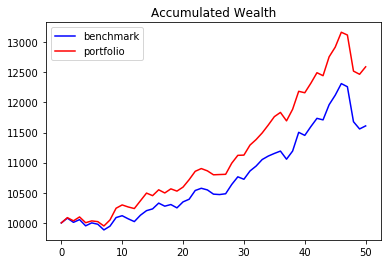

In [91]:
plt.figure(1)
plt.title("Accumulated Wealth")
plt.plot(range(len(benchmark_value)),benchmark_value,'b',label="benchmark")
plt.plot(range(len(portfolio_value)),portfolio_value,'r',label="portfolio")
plt.legend()
plt.show()